# Gesture Recognition
In this project, the objective is to build a 3D Conv model that will be able to predict the 5 gestures correctly. This project is for a home electronics company which manufactures state of the art smart televisions. The company wants to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

### Training Data

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

### The Workhorse
 Nvidia Quadro RTX 6000 GPU was used for this entire project. Details during a training process are given below. This info is fetched by running nvidia-smi in the termial.

In [4]:
     
#+---------------------------------------------------------------------------------------+
#| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
#|-----------------------------------------+----------------------+----------------------+
#| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
#| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
#|                                         |                      |               MIG M. |
#|=========================================+======================+======================|
#|   0  Quadro RTX 6000                Off | 00000000:1D:00.0 Off |                  Off |
#| 34%   49C    P2              66W / 260W |   9590MiB / 24576MiB |      0%      Default |
#|                                         |                      |                  N/A |
#+-----------------------------------------+----------------------+----------------------+
#                                                                                         
#+---------------------------------------------------------------------------------------+
#| Processes:                                                                            |
#|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
#|        ID   ID                                                             Usage      |
#|=======================================================================================|
#|    0   N/A  N/A      4917      G   python                                        4MiB |
#+---------------------------------------------------------------------------------------+

Importing the necessary libraries. ML/DL libraries are imported as and when required.

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os
from skimage.transform import resize
from skimage.util import crop
from skimage import io
# using skimage libraries for reading, resizing and cropping images
import matplotlib.pyplot as plt
from keras.utils import plot_model

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, the folder names are read for training and validation. 

**data path: /home/datasets/Project_data**

In [4]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())


## Generator
This is one of the most important part of the code. The generator function feeds the network for every epoch since the entire data is not possible to be considered at once in the memory due to resource constraints. In the generator, images are preprocessed too since 2 different dimensions of images are present 360x360 and 120x160. In this entire project, square aspect ratio imgaes are considerd. The input to the function are the source path(training/validation), list of items, batch size, number of images considered in each sequence, image size. Image sizes and number of images in each sequences are experimented.

This generator function takes in batch_size, number of images to be considered for training for each instance, final image size to be considered. The generator function transforms the image upon each iteration to the image size required using cropping and resizing. skimage libraries are used for the same

In [7]:
def generator(source_path, folder_list, batch_size, img_idx, image_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_size,image_size,3)) # batch size, number of images considered frome ach data point, image size in x and y directions and RGB channels
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:  # Code to resize and crop based on the incoming image size
                        crop_amount = ((120 - 120) // 2, (160 - 120) // 2)     
                        image = crop(image, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))
                        image = resize(image, (image_size,image_size))
                    else:
                        image = resize(image, (image_size,image_size))
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # normalization of RGB channels
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches, same above code, but with condition if (len(folder_list) % batch_size) != 0:
        if (len(folder_list) % batch_size) != 0:
            print("Batch: ",num_batches+1,"Index:", batch_size, "Remaining data code")
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),image_size,image_size,3)) 
            batch_labels = np.zeros((batch_size,5)) 
            for folder in range(batch_size): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx): 
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        crop_amount = ((120 - 120) // 2, (160 - 120) // 2)     
                        image = crop(image, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0)))
                        image = resize(image, (image_size,image_size))
                    else:
                        image = resize(image, (image_size,image_size))

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). 

Sample Cropping and resizing of images

In [101]:
# Load an image of size 120x160
img = io.imread('/home/datasets/Project_data/train/WIN_20180925_17_20_16_Pro_Thumbs_Up_new/WIN_20180925_17_20_16_Pro_00012.png')
img.shape

(120, 160, 3)

It can be seen that the image is of size 120x160x3 ie height x width x no. of channels

Rendering the image

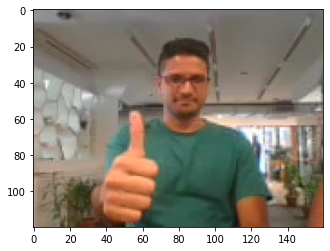

In [104]:
plt.imshow(img)
plt.show()

Cropping and resizing

In [106]:
h, w, _ = img.shape
if h == 120 and w == 160:
    # Calculate the amount to crop from each side
    crop_amount = ((h - 120) // 2, (w - 120) // 2)    
    # Crop the image
    img_cropped = crop(img, ((crop_amount[0], crop_amount[0]), (crop_amount[1], crop_amount[1]), (0, 0))) 
    img_resized = resize(img_cropped, (80,80))   # resize the image as required
    print(f"The cropped image has a size of {img_cropped.shape}.")
    print(f"The resized image has a size of {img_resized.shape}.")
else:
    img_resized = resize(img, (80,80))
    print(f"The resized image has a size of {img.shape}.")

The cropped image has a size of (120, 120, 3).
The resized image has a size of (80, 80, 3).


Plotting the cropped image

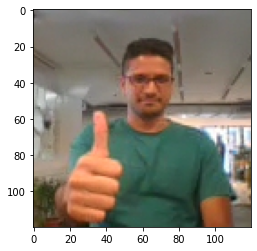

In [107]:
plt.imshow(img_cropped)
plt.show()
#Plotting the cropped image

Plotting the resized image

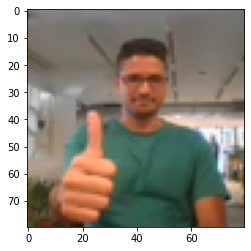

In [108]:
plt.imshow(img_resized)
plt.show()
#Plotting the resized image

Defining the training parameters- epoch, train sequences, validation sequences etc

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


Defining a function to plot training and validation accuracies and corresponding loss values

In [5]:
def plot_graph(model_history): # getting model hsitory
    import matplotlib.pyplot as plt
    acc = model_history.history['categorical_accuracy'] # choosing training accuracy
    val_acc = model_history.history['val_categorical_accuracy'] # Choosing the validation accuracy

    loss = model_history.history['loss'] # Choosing training loss
    val_loss = model_history.history['val_loss'] # Choosing validation loss

    epochs_range = range(len(loss))
    #Code to plot the graphs
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Model
Models are being tried out using different functionalities that Keras provides. we are using 3D conv network for the models, the thrird dimension being the time series frames in a video. Last layer is the softmax, with 5 class classification. The objective is to build a model that is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

#Importing required libraries for model training

Defining the first model 'model'. From the previous experiences with CNN, it is observed that dropouts are helping to minimize overfitting in the case of dense layers. Therefore adding the same in the first model itself. Later, various models are experimented without dropouts, and with batch normalization etc<br>
first 22 images are considered(skipping zero) since it is generally observed after exploratory data analysis that gestures are not present towards the last part of the video.

In [9]:
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] #Initiating the image indexes for first iteration

In [22]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model1 = Sequential()#defining a sequential CNN model.

# model architecture


model1.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))#3Dconvolution layer with 3x3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model1.add(Activation('relu'))#activation function for the convolution layer
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))#3D Maxpooling layer-derives maximum values in a matrix of 2x2x2. Basically halves the dimensions in effect

model1.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same'))#3D convolution layer with 3x3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model1.add(Activation('relu'))#activation function for the convolution layer
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model1.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))#3D convolution layer with 3x3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model1.add(Activation('relu'))#activation function for the convolution layer
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization())

model1.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))# 3D convolution layer with 3x3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model1.add(Activation('relu'))#activation function for the convolution layer
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))
model1.add(BatchNormalization())

model1.add(Flatten())#Flattening the matrix to 1D vector for the dense layer to act upon
model1.add(Dense(64))#Dense layer(the normal neural network)
model1.add(Activation('relu'))
model1.add(Dropout(0.3))
model1.add(Dense(64))#Dense layer(the normal neural network)
model1.add(Activation('relu'))
model1.add(Dropout(0.3))
model1.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model1.add(Activation('softmax'))#Softmax function for the probabilities of each classes

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [24]:
optimiser = 'adam'#Adam is considered as it is used for faster convergence
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 22, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 22, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 11, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 60, 60, 32)    13856     
                                                                 
 activation_8 (Activation)   (None, 11, 60, 60, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 5, 30, 30, 32)    0         
 3D)                                                  

Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Trying with an image size of 120 x 120. 120x120 is the best square aspect ratio image which can be derived from the training data of two sizes 360x360 and 120x160, without enlarging the images. Enlarging the images is not recommended since it can add noise to the data.

Batch size of 12 is considered as a start and first 22 images are considered(skipping zero) since it is generally observed that gestures are not present towards the last of the video.

In [25]:
image_size = 120  #Size of the final image required-only unit aspect ratio is considered as the worst dimension oberved is 160x120, out of which the best crop can be 120x120 square image
print ('# Final image size =', image_size)
batch_size = 12  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)

# Final image size = 120
# Batch Size = 12
# Length of image index:  22
# Image indices to be considered:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


Defining early stops, call backs, learning rate plateau, model name to be saved

In [26]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# If the categorical accuracy on the validation set doesn’t improve for 5 epochs, reduce the learning rate by multiplying by by 0.2. New lr = LR*0.2. Lower limit is 0.0001 to prevent LR from going below 0.0001

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=5,mode="auto",verbose=1)#Early stopping is set up to save resources and time if accuracy is not improving over 5 continuous epochs
callbacks_list = [checkpoint, LR, earlystop]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [28]:
model1_history = model1.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/2363790828.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1_history = model1.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 2.0384 - categorical_accuracy: 0.2911Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12 Remaining data code

Epoch 00001: val_categorical_accuracy improved from -inf to 0.27000, saving model to model_init_2024-04-3009_36_22.767061/model-00001-2.03842-0.29110.h5
56/56 [==============================] - 183s 3s/step - loss: 2.0384 - categorical_accuracy: 0.2911 - val_loss: 1.9022 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.6782 - categorical_accuracy: 0.2143
Epoch 00002: val_categorical_accuracy did not improve from 0.27000
56/56 [==============================] - 42s 753ms/step - loss: 1.6782 - categorical_accuracy: 0.2143 - val_loss: 1.6172 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s 

Plotting the accuracies and losses for 1st model 'model'

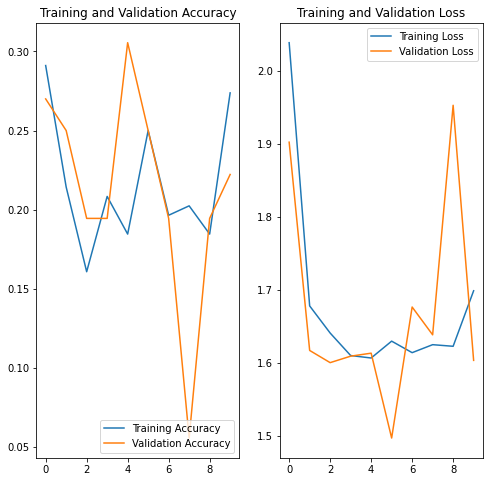

In [29]:
plot_graph(model1_history)

In [84]:
ind = model1_history.history['val_categorical_accuracy'].index(max(model1_history.history['val_categorical_accuracy']))
model1_val_acc = max(model1_history.history['val_categorical_accuracy'])
model1_trg_acc = model1_history.history['categorical_accuracy'][ind]
model1_params = model1.count_params()
print("Maximum validation accuracy:", model1_val_acc)
print("Corresponding training accuracy:", model1_trg_acc)
print("Corresponding number of parameters:", model1_params)

Maximum validation accuracy: 0.3055555522441864
Corresponding training accuracy: 0.184523805975914
Corresponding number of parameters: 698565


Accuracies are not upto mark.Changing the model architecture. The second model name assigned is 'model2'

In [31]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model2 = Sequential()#defining a sequential CNN model.

# model architecture

model2.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),120,120,3)))#3D convolution layer with 3x3x3 window or the kernel, padding= 'same' means the output will be of the same dimensions as the input to this layer.
model2.add(Activation('relu'))#activation function for the convolution layer
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))#3D Maxpooling layer-derives maximum values in a matrix of 2x2x2. Basically halves the dimensions in effect

model2.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(filters = 256, kernel_size = (3, 3, 3), padding ='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization()) #BAtch normalization is tried for the last Conv layer.

model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(128))
model2.add(Activation('relu'))
model2.add(Dropout(0.3))
model2.add(Dense(5))
model2.add(Activation('softmax'))

optimizer = 'adam'
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 22, 120, 120, 64)  5248      
                                                                 
 activation_14 (Activation)  (None, 22, 120, 120, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 11, 60, 60, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 60, 60, 128)   221312    
                                                                 
 activation_15 (Activation)  (None, 11, 60, 60, 128)   0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 30, 30, 128)   0         
 3D)                                                  

In [32]:
model2_history = model2.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/3402054644.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2_history = model2.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 11.8345 - categorical_accuracy: 0.2560
Epoch 00001: val_categorical_accuracy improved from 0.30556 to 0.33333, saving model to model_init_2024-04-3009_36_22.767061/model-00001-11.83452-0.25595.h5
56/56 [==============================] - 42s 741ms/step - loss: 11.8345 - categorical_accuracy: 0.2560 - val_loss: 18.6073 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 4.1439 - categorical_accuracy: 0.2381
Epoch 00002: val_categorical_accuracy did not improve from 0.33333
56/56 [==============================] - 44s 797ms/step - loss: 4.1439 - categorical_accuracy: 0.2381 - val_loss: 18.1729 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 2.5057 - categorical_accuracy: 0.2679
Epoch 00003: val_categorical_accuracy did not improve from 0.33333
56/56 [==============================] - 46s 832m

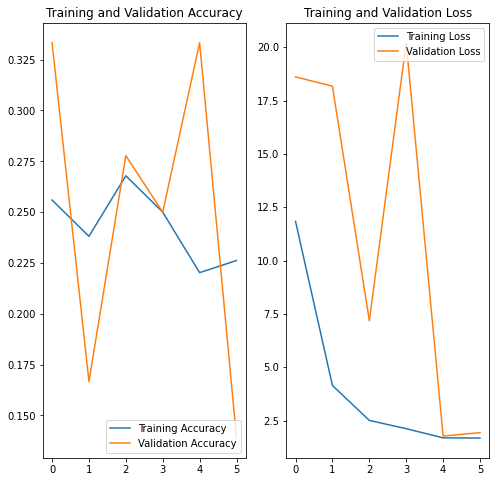

In [33]:
plot_graph(model2_history)

In [85]:
ind = model2_history.history['val_categorical_accuracy'].index(max(model2_history.history['val_categorical_accuracy']))
model2_val_acc = max(model2_history.history['val_categorical_accuracy'])
model2_trg_acc = model2_history.history['categorical_accuracy'][ind]
model2_params = model2.count_params()
print("Maximum validation accuracy:", model2_val_acc)
print("Corresponding training accuracy:", model2_trg_acc)
print("Corresponding number of parameters:", model2_params)

Maximum validation accuracy: 0.3333333432674408
Corresponding training accuracy: 0.255952388048172
Corresponding number of parameters: 15875461


From the above graph it can be seen that the Model performance dropped when more neurons wre added.

Trying with a reduced image size of 80x80 and usign an architecture with reduced number of neurons

In [35]:
image_size = 80  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 12  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)

# Final image size = 80
# Batch Size = 12
# Length of image index:  22
# Image indices to be considered:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [37]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model3 = Sequential()#defining a sequential CNN model.

# model architecture
model3.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),image_size,image_size,3)))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(filters = 32, kernel_size = (3, 3, 3), padding ='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding ='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization())

model3.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding ='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(5))
model3.add(Activation('softmax'))


optimizer = 'adam'
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 22, 120, 120, 64)  5248      
                                                                 
 activation_14 (Activation)  (None, 22, 120, 120, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 11, 60, 60, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 11, 60, 60, 128)   221312    
                                                                 
 activation_15 (Activation)  (None, 11, 60, 60, 128)   0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 5, 30, 30, 128)   0         
 3D)                                                  

In [38]:
model3_history = model3.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/3712908193.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3_history = model3.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.7254 - categorical_accuracy: 0.3273Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12 Remaining data code

Epoch 00001: val_categorical_accuracy did not improve from 0.33333
56/56 [==============================] - 156s 3s/step - loss: 1.7254 - categorical_accuracy: 0.3273 - val_loss: 1.6661 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.9546 - categorical_accuracy: 0.3095
Epoch 00002: val_categorical_accuracy did not improve from 0.33333
56/56 [==============================] - 42s 771ms/step - loss: 1.9546 - categorical_accuracy: 0.3095 - val_loss: 4.4662 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.8470 - categorical_accuracy: 0.2619
Epoch 00003: val_categorical_accuracy di

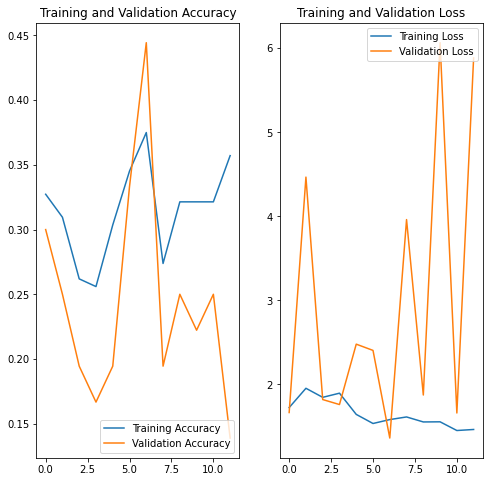

In [39]:
plot_graph(model3_history)

In [86]:
ind = model3_history.history['val_categorical_accuracy'].index(max(model3_history.history['val_categorical_accuracy']))
model3_val_acc = max(model3_history.history['val_categorical_accuracy'])
model3_trg_acc = model3_history.history['categorical_accuracy'][ind]
model3_params = model3.count_params()
print("Maximum validation accuracy:", model3_val_acc)
print("Corresponding training accuracy:", model3_trg_acc)
print("Corresponding number of parameters:", model3_params)

Maximum validation accuracy: 0.4444444477558136
Corresponding training accuracy: 0.375
Corresponding number of parameters: 501957


It can be seen that the accuracy of the 3rd model is also not upto mark

Trying with a denser model with more number of neurons and 80x80 image size and batch size of 12

In [46]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)

# Final image size = 120
# Batch Size = 32
# Length of image index:  22
# Image indices to be considered:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [47]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model4 = Sequential()#defining a sequential CNN model.

# model architecture

model4.add(Conv3D(filters = 512, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),image_size,image_size,3)))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(filters = 256, kernel_size = (3, 3, 3), padding ='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(BatchNormalization())

model4.add(Flatten())
model4.add(Dense(128))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))
model4.add(Dense(64))
model4.add(Activation('relu'))
model4.add(Dropout(0.3))
model4.add(Dense(5))
model4.add(Activation('softmax'))


optimizer = 'adam'
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 22, 120, 120, 512  41984     
                             )                                   
                                                                 
 activation_32 (Activation)  (None, 22, 120, 120, 512  0         
                             )                                   
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 11, 60, 60, 512)  0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 11, 60, 60, 256)   3539200   
                                                                 
 activation_33 (Activation)  (None, 11, 60, 60, 256)   0         
                                                      

In [48]:
model4_history = model4.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/874038354.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4_history = model4.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-04-30 10:57:24.588767: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 19.34GiB (rounded to 20761804800)requested by op sequential_6/conv3d_17/Conv3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-04-30 10:57:24.588863: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2024-04-30 10:57:24.588892: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 237, Chunks in use: 236. 59.2KiB allocated for chunks. 59.0KiB in use in bin. 18.0KiB client-requested in use in bin.
2024-04-30 10:57:24.588924: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 49, Chunks in use: 49. 25.5KiB allocated for chunks. 25.5KiB in use in bin. 24.6KiB client-requested in use in bin.
202

ResourceExhaustedError:  OOM when allocating tensor with shape[32,512,22,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_6/conv3d_17/Conv3D
 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py:231)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_20245]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_6/conv3d_17/Conv3D:
In[0] IteratorGetNext (defined at /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:866)	
In[1] sequential_6/conv3d_17/Conv3D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_1025/874038354.py", line 1, in <module>
>>>     model4_history = model4.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2016, in fit_generator
>>>     return self.fit(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

It can be seen that the number of neurons which can be used in the model is constrained by the memory available. In this case, OOM error is being thrown since the GPU memory is not enough to process these many neurons. Even Nvidia Quadro RTX 5000 is not enough. May be, reduction in the batch size might help. Trying out the same model with reductin in batch size

Trying out a different model with reduced number of neurons and lesser depth in feature extraction. Image size is 

In [49]:
image_size = 80  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 4  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)

# Final image size = 80
# Batch Size = 4
# Length of image index:  22
# Image indices to be considered:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [50]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [51]:
## Model explanations are done only for the first istance since it is essential same for all the models. However if new layers are introduced like Dropouts, explanations are provided then and there itself.
model5 = Sequential()#defining a sequential CNN model.

# model architecture

model5.add(Conv3D(filters = 512, kernel_size = (3, 3, 3), padding ='same', input_shape = (len(img_idx),image_size,image_size,3)))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))

model5.add(Conv3D(filters = 256, kernel_size = (3, 3, 3), padding ='same'))
model5.add(Activation('relu'))
model5.add(MaxPooling3D(pool_size=(2, 2, 2)))
model5.add(BatchNormalization())

model5.add(Flatten())
model5.add(Dense(128))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))
model5.add(Dense(64))
model5.add(Activation('relu'))
model5.add(Dropout(0.3))
model5.add(Dense(5))
model5.add(Activation('softmax'))


optimizer = 'adam'
model5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_19 (Conv3D)          (None, 22, 80, 80, 512)   41984     
                                                                 
 activation_37 (Activation)  (None, 22, 80, 80, 512)   0         
                                                                 
 max_pooling3d_19 (MaxPoolin  (None, 11, 40, 40, 512)  0         
 g3D)                                                            
                                                                 
 conv3d_20 (Conv3D)          (None, 11, 40, 40, 256)   3539200   
                                                                 
 activation_38 (Activation)  (None, 11, 40, 40, 256)   0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 5, 20, 20, 256)   0         
 g3D)                                                 

In [52]:
model5_history = model5.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/192434988.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5_history = model5.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/20
166/166 [==============================] - ETA: 0s - loss: 17.3810 - categorical_accuracy: 0.1991Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_categorical_accuracy did not improve from 0.44444
166/166 [==============================] - 124s 741ms/step - loss: 17.3810 - categorical_accuracy: 0.1991 - val_loss: 8.2424 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
166/166 [==============================] - ETA: 0s - loss: 1.6902 - categorical_accuracy: 0.2008
Epoch 00002: val_categorical_accuracy did not improve from 0.44444
166/166 [==============================] - 88s 532ms/step - loss: 1.6902 - categorical_accuracy: 0.2008 - val_loss: 1.9240 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/20
166/166 [==============================] - ETA: 0s - loss: 1.6731 - categorical_accuracy: 0.2048
Epoch 00003: val_categorical_accuracy did not improve from 0.44444


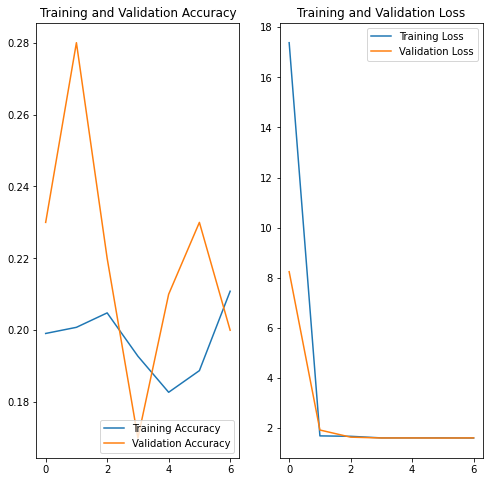

In [53]:
plot_graph(model5_history)

In [87]:
ind = model5_history.history['val_categorical_accuracy'].index(max(model5_history.history['val_categorical_accuracy']))
model5_val_acc = max(model5_history.history['val_categorical_accuracy'])
model5_trg_acc = model5_history.history['categorical_accuracy'][ind]
model5_params = model5.count_params()
print("Maximum validation accuracy:", model5_val_acc)
print("Corresponding training accuracy:", model5_trg_acc)
print("Corresponding number of parameters:", model5_params)

Maximum validation accuracy: 0.2800000011920929
Corresponding training accuracy: 0.2008032202720642
Corresponding number of parameters: 69126917


It can be seen that a more dense 1st layer with 512 neurons drastically reduced the accuracy of the model.<br>It can be observed that OOM error is not thrown when the batch size was reduced. The new batch wise size of input could be accommodated in the GPU and therefore OOM error was not thrown<br>Thr results are not encouraging

Let us try with a model with an architecture with reduced number of neurons. and batch normalization at every layer. <br> Since the number of neurons were reduced, batch size has been increased to 12

In [55]:
image_size = 80  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 12  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)

# Final image size = 80
# Batch Size = 12
# Length of image index:  22
# Image indices to be considered:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [57]:
model6 = Sequential()
model6.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Conv3D(filters = 128, kernel_size = (3, 3, 3),padding='same'))
model6.add(Activation('relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling3D(pool_size=(2, 2, 2)))

model6.add(Flatten())
model6.add(Dense(64,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))

model6.add(Dense(64,activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.3))


model6.add(Dense(5))
model6.add(Activation('softmax'))


optimizer = 'adam'
model6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 22, 80, 80, 16)    1312      
                                                                 
 activation_42 (Activation)  (None, 22, 80, 80, 16)    0         
                                                                 
 batch_normalization_10 (Bat  (None, 22, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 11, 40, 40, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 11, 40, 40, 32)    13856     
                                                                 
 activation_43 (Activation)  (None, 11, 40, 40, 32)   

In [58]:
model6_history = model6.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/604441966.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model6_history = model6.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.6289 - categorical_accuracy: 0.3952Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12 Remaining data code

Epoch 00001: val_categorical_accuracy did not improve from 0.44444
56/56 [==============================] - 113s 2s/step - loss: 1.6289 - categorical_accuracy: 0.3952 - val_loss: 2.5540 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7099 - categorical_accuracy: 0.3631
Epoch 00002: val_categorical_accuracy did not improve from 0.44444
56/56 [==============================] - 32s 574ms/step - loss: 1.7099 - categorical_accuracy: 0.3631 - val_loss: 3.5659 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.9499 - categorical_accuracy: 0.2798
Epoch 00003: val_categorical_accuracy di

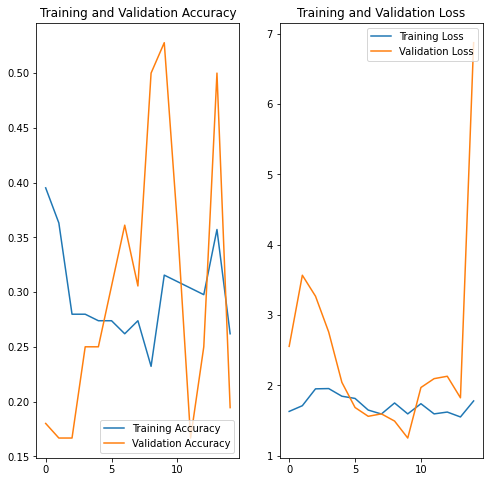

In [59]:
plot_graph(model6_history)

In [88]:
ind = model6_history.history['val_categorical_accuracy'].index(max(model6_history.history['val_categorical_accuracy']))
model6_val_acc = max(model6_history.history['val_categorical_accuracy'])
model6_trg_acc = model6_history.history['categorical_accuracy'][ind]
model6_params = model6.count_params()
print("Maximum validation accuracy:", model6_val_acc)
print("Corresponding training accuracy:", model6_trg_acc)
print("Corresponding number of parameters:", model6_params)

Maximum validation accuracy: 0.5277777910232544
Corresponding training accuracy: 0.3154761791229248
Corresponding number of parameters: 502661


It can be observed that the validation accuracy further got reduced.<br> Trying with a bigger image of size 120x120 and removing batch normalization and trying out with maximum number of images

In [61]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 12  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 23, 24, 25,26,27,28,29]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 12
# Length of image index:  30
# Image indices to be considered:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# Number of epochs:  20


In [62]:
model7 = Sequential()
model7.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Conv3D(filters = 128, kernel_size = (3, 3, 3),padding='same'))
model7.add(Activation('relu'))
model7.add(MaxPooling3D(pool_size=(2, 2, 2)))

model7.add(Flatten())
model7.add(Dense(64,activation='relu'))
model7.add(Dropout(0.3))

model7.add(Dense(64,activation='relu'))
model7.add(Dropout(0.3))


model7.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model7.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model7.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_25 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_47 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_26 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_48 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                 

In [64]:
model7_history = model7.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/3032491426.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model7_history = model7.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.6151 - categorical_accuracy: 0.2127Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12 Remaining data code

Epoch 00001: val_categorical_accuracy did not improve from 0.52778
56/56 [==============================] - 176s 3s/step - loss: 1.6151 - categorical_accuracy: 0.2127 - val_loss: 1.6086 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.6106 - categorical_accuracy: 0.1964
Epoch 00002: val_categorical_accuracy did not improve from 0.52778
56/56 [==============================] - 38s 690ms/step - loss: 1.6106 - categorical_accuracy: 0.1964 - val_loss: 1.6077 - val_categorical_accuracy: 0.1944 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.6094 - categorical_accuracy: 0.2143
Epoch 00003: val_categorical_accuracy di

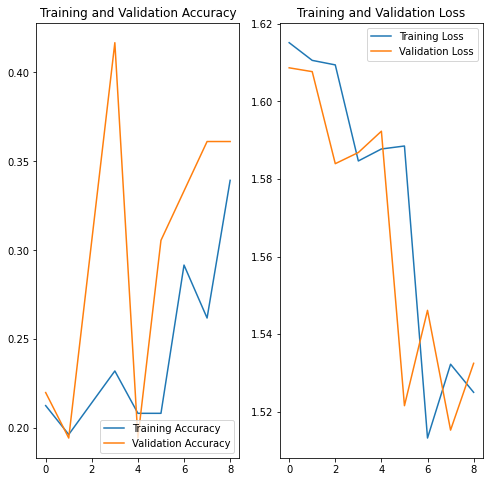

In [65]:
plot_graph(model7_history)

In [89]:
ind = model7_history.history['val_categorical_accuracy'].index(max(model7_history.history['val_categorical_accuracy']))
model7_val_acc = max(model7_history.history['val_categorical_accuracy'])
model7_trg_acc = model7_history.history['categorical_accuracy'][ind]
model7_params = model7.count_params()
print("Maximum validation accuracy:", model7_val_acc)
print("Corresponding training accuracy:", model7_trg_acc)
print("Corresponding number of parameters:", model7_params)

Maximum validation accuracy: 0.4166666567325592
Corresponding training accuracy: 0.2321428507566452
Corresponding number of parameters: 697797


It can be seen that there is slight reduction in accuracy. We can try increasing the number of neurons in the dense layers and if it helps in the correct classification.

In [67]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 12  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 23, 24, 25,26,27,28,29]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 12
# Length of image index:  30
# Image indices to be considered:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# Number of epochs:  20


In [68]:
model8 = Sequential()
model8.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))
model8.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Conv3D(filters = 128, kernel_size = (3, 3, 3),padding='same'))
model8.add(Activation('relu'))
model8.add(MaxPooling3D(pool_size=(2, 2, 2)))

model8.add(Flatten())
model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.3))

model8.add(Dense(128,activation='relu'))
model8.add(Dropout(0.3))


model8.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model8.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model8.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_29 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_30 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_53 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_30 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                

In [69]:
model8_history = model8.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/1774539517.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model8_history = model8.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 12
Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 1.5770 - categorical_accuracy: 0.2368Source path =  /home/datasets/Project_data/val ; batch size = 12
Batch:  9 Index: 12 Remaining data code

Epoch 00001: val_categorical_accuracy did not improve from 0.52778
56/56 [==============================] - 189s 3s/step - loss: 1.5770 - categorical_accuracy: 0.2368 - val_loss: 1.4264 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.5332 - categorical_accuracy: 0.2500
Epoch 00002: val_categorical_accuracy did not improve from 0.52778
56/56 [==============================] - 42s 760ms/step - loss: 1.5332 - categorical_accuracy: 0.2500 - val_loss: 1.5794 - val_categorical_accuracy: 0.3056 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 1.5323 - categorical_accuracy: 0.3214
Epoch 00003: val_categorical_accuracy di

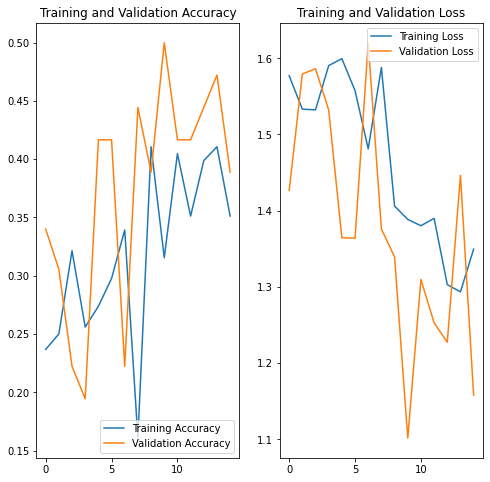

In [70]:
plot_graph(model8_history)

In [90]:
ind = model8_history.history['val_categorical_accuracy'].index(max(model8_history.history['val_categorical_accuracy']))
model8_val_acc = max(model8_history.history['val_categorical_accuracy'])
model8_trg_acc = model8_history.history['categorical_accuracy'][ind]
model8_params = model8.count_params()
print("Maximum validation accuracy:", model8_val_acc)
print("Corresponding training accuracy:", model8_trg_acc)
print("Corresponding number of parameters:", model8_params)

Maximum validation accuracy: 0.5
Corresponding training accuracy: 0.3154761791229248
Corresponding number of parameters: 1111941


The accuracy got reduced slightly increased when the number of neurons in the dense layer got increased. Now trying out with a simpler architecture and increased batch size to 32. Full range of images are used for training

In [72]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=5,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [73]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22, 23, 24, 25,26,27,28,29]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  30
# Image indices to be considered:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# Number of epochs:  20


In [74]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [75]:
model9 = Sequential()
model9.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model9.add(Activation('relu'))
model9.add(MaxPooling3D(pool_size=(2, 2, 2)))

model9.add(Flatten())
model9.add(Dense(64,activation='relu'))
model9.add(Dropout(0.3))


model9.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model9.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model9.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_57 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_34 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_58 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                

In [76]:
model9_history = model9.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/3479583896.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model9_history = model9.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.8337 - categorical_accuracy: 0.2081Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3009_36_22.767061/model-00001-1.83370-0.20814-1.59356-0.21000.h5
21/21 [==============================] - 147s 7s/step - loss: 1.8337 - categorical_accuracy: 0.2081 - val_loss: 1.5936 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5630 - categorical_accuracy: 0.2567
Epoch 00002: saving model to model_init_2024-04-3009_36_22.767061/model-00002-1.56305-0.25673-1.52365-0.31250.h5
21/21 [==============================] - 93s 5s/step - loss: 1.5630 - categorical_accuracy: 0.2567 - val_loss: 1.5236 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 

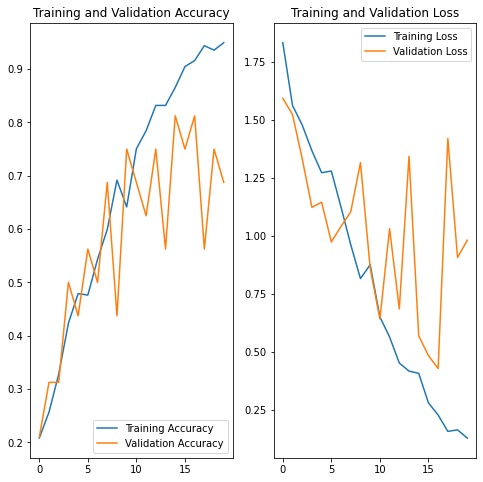

In [82]:
plot_graph(model9_history)

It can be observed that the validation accuracy is 0.8125 and the corresponding training accuracy is 0.8655. This model seems to perform better with very litte overfitting

In [91]:
ind = model9_history.history['val_categorical_accuracy'].index(max(model9_history.history['val_categorical_accuracy']))
model9_val_acc = max(model9_history.history['val_categorical_accuracy'])
model9_trg_acc = model9_history.history['categorical_accuracy'][ind]
model9_params = model9.count_params()
print("Maximum validation accuracy:", model9_val_acc)
print("Corresponding training accuracy:", model9_trg_acc)
print("Corresponding number of parameters:", model9_params)

Maximum validation accuracy: 0.8125
Corresponding training accuracy: 0.8655462265014648
Corresponding number of parameters: 2835717


Already we have model (model9) with sufficiently good accuracy. Let's experiment further and see if we can get much more good accuracy. Slightly modifying the model by additing BatchNormalization layer. The new model is model10. <br>Batch size is 32, image size is 120x120 and all images in the sequence is used, just as in the case of model9

In [92]:
model10 = Sequential()
model10.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))

model10.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model10.add(Activation('relu'))
model10.add(MaxPooling3D(pool_size=(2, 2, 2)))
model10.add(BatchNormalization())

model10.add(Flatten())
model10.add(Dense(64,activation='relu'))
model10.add(Dropout(0.3))


model10.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model10.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model10.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_65 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_40 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 activation_66 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                

In [93]:
model10_history = model10.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/3215623786.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model10_history = model10.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.4842 - categorical_accuracy: 0.3053
Epoch 00001: saving model to model_init_2024-04-3009_36_22.767061/model-00001-2.48424-0.30532-1.60429-0.18750.h5
21/21 [==============================] - 71s 4s/step - loss: 2.4842 - categorical_accuracy: 0.3053 - val_loss: 1.6043 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4451 - categorical_accuracy: 0.3053
Epoch 00002: saving model to model_init_2024-04-3009_36_22.767061/model-00002-1.44510-0.30532-1.89820-0.18750.h5
21/21 [==============================] - 68s 3s/step - loss: 1.4451 - categorical_accuracy: 0.3053 - val_loss: 1.8982 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2956 - categorical_accuracy: 0.4230
Epoch 00003: saving model to model_init_2024-04-3009_36_22.767061/model-00003-1.29556-0.42297-1.54456-0.25000.h5
21/21 [====

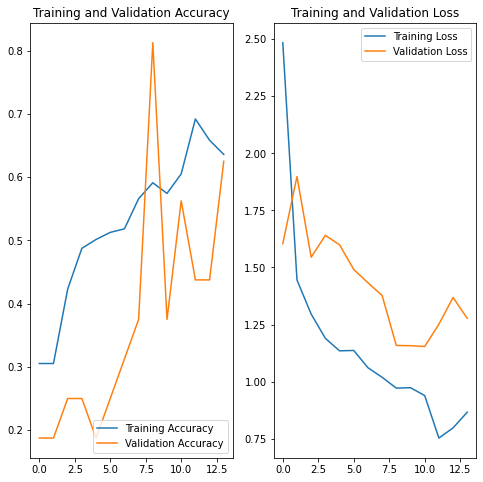

In [94]:
plot_graph(model10_history)

In [95]:
ind = model10_history.history['val_categorical_accuracy'].index(max(model10_history.history['val_categorical_accuracy']))
model10_val_acc = max(model10_history.history['val_categorical_accuracy'])
model10_trg_acc = model10_history.history['categorical_accuracy'][ind]
model10_params = model10.count_params()
print("Maximum validation accuracy:", model10_val_acc)
print("Corresponding training accuracy:", model10_trg_acc)
print("Corresponding number of parameters:", model10_params)

Maximum validation accuracy: 0.8125
Corresponding training accuracy: 0.5910364389419556
Corresponding number of parameters: 2835973


It can be observed that adding a Batch Normalization layer is not helping to improve the validation accuracy. Rather the training accuracy got reduced.

It can be seen that model 9 has the maximum accuracy observed, which is the simplest model and reasonablly less number of parameters

In [96]:

print("Maximum validation accuracy:", model9_val_acc)
print("Corresponding training accuracy:", model9_trg_acc)
print("Corresponding number of parameters:", model9_params)

Maximum validation accuracy: 0.8125
Corresponding training accuracy: 0.8655462265014648
Corresponding number of parameters: 2835717


Experimenting with model no. 9 as the base which showed the best accuracy so far and not much of overfitting....In the new iteration of model 9, the number of input images are reduced to 15, taking only the 15numbers around the median ie from 8 to 22 frames.

In [97]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=5,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [98]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  15
# Image indices to be considered:  [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
# Number of epochs:  20


In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [100]:
model11 = Sequential()
model11.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model11.add(Activation('relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))

model11.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model11.add(Activation('relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))

model11.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model11.add(Activation('relu'))
model11.add(MaxPooling3D(pool_size=(2, 2, 2)))

model11.add(Flatten())
model11.add(Dense(64,activation='relu'))
model11.add(Dropout(0.3))


model11.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model11.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model11.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model11.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_69 (Activation)  (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_42 (MaxPoolin  (None, 7, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_43 (Conv3D)          (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_70 (Activation)  (None, 7, 60, 60, 32)     0         
                                                                 
 max_pooling3d_43 (MaxPoolin  (None, 3, 30, 30, 32)    0         
 g3D)                                                

In [109]:
model11_history = model11.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/129431019.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model11_history = model11.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5965 - categorical_accuracy: 0.2474Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3009_36_22.767061/model-00001-1.59650-0.24736-1.53352-0.37000.h5
21/21 [==============================] - 76s 4s/step - loss: 1.5965 - categorical_accuracy: 0.2474 - val_loss: 1.5335 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5127 - categorical_accuracy: 0.3209
Epoch 00002: saving model to model_init_2024-04-3009_36_22.767061/model-00002-1.51274-0.32091-1.47284-0.31250.h5
21/21 [==============================] - 48s 2s/step - loss: 1.5127 - categorical_accuracy: 0.3209 - val_loss: 1.4728 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

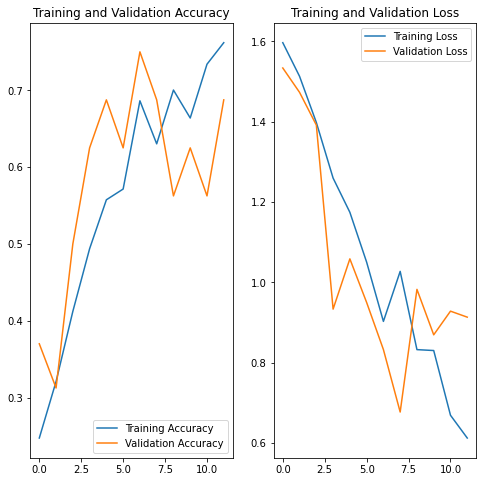

In [110]:
plot_graph(model11_history)

In [111]:
ind = model11_history.history['val_categorical_accuracy'].index(max(model11_history.history['val_categorical_accuracy']))
model11_val_acc = max(model11_history.history['val_categorical_accuracy'])
model11_trg_acc = model11_history.history['categorical_accuracy'][ind]
model11_params = model11.count_params()
print("Maximum validation accuracy:", model11_val_acc)
print("Corresponding training accuracy:", model11_trg_acc)
print("Corresponding number of parameters:", model11_params)

Maximum validation accuracy: 0.75
Corresponding training accuracy: 0.686274528503418
Corresponding number of parameters: 992517


Accuracy didn't increase with the reduced number of frames in the input, centred around the median. Now we'll try with the last 15 images and the same model architecture at model no. 9. Increased the early stopping patience to 10 just to see if it helps in getting a better accuracy down the line after more number of epochs

In [112]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=10,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [8]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [15,16,17,18,19,20,21,22, 23, 24, 25,26,27,28,29]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  15
# Image indices to be considered:  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# Number of epochs:  20


In [11]:
model12 = Sequential()
model12.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model12.add(Activation('relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))

model12.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model12.add(Activation('relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))

model12.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model12.add(Activation('relu'))
model12.add(MaxPooling3D(pool_size=(2, 2, 2)))

model12.add(Flatten())
model12.add(Dense(64,activation='relu'))
model12.add(Dropout(0.3))


model12.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model12.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model12.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model12.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 60, 60, 16)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 60, 60, 32)     0         
                                                      

In [115]:
model12_history = model12.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_1025/2262134972.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model12_history = model12.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6231 - categorical_accuracy: 0.2398Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3009_36_22.767061/model-00001-1.62314-0.23982-1.54137-0.23000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.6231 - categorical_accuracy: 0.2398 - val_loss: 1.5414 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5244 - categorical_accuracy: 0.3126
Epoch 00002: saving model to model_init_2024-04-3009_36_22.767061/model-00002-1.52441-0.31263-1.56186-0.18750.h5
21/21 [==============================] - 77s 4s/step - loss: 1.5244 - categorical_accuracy: 0.3126 - val_loss: 1.5619 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

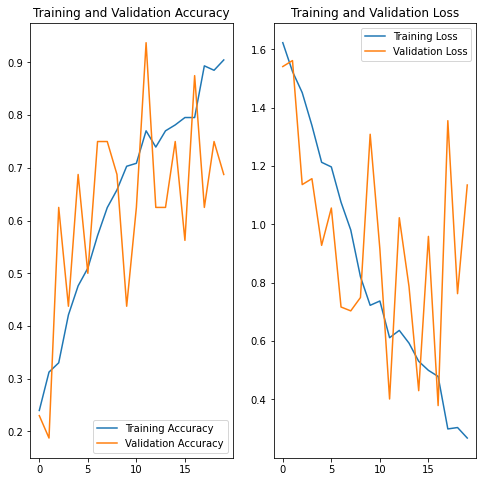

In [116]:
plot_graph(model12_history)

In [117]:
ind = model12_history.history['val_categorical_accuracy'].index(max(model12_history.history['val_categorical_accuracy']))
model12_val_acc = max(model12_history.history['val_categorical_accuracy'])
model12_trg_acc = model12_history.history['categorical_accuracy'][ind]
model12_params = model12.count_params()
print("Maximum validation accuracy:", model12_val_acc)
print("Corresponding training accuracy:", model12_trg_acc)
print("Corresponding number of parameters:", model12_params)

Maximum validation accuracy: 0.9375
Corresponding training accuracy: 0.7703081369400024
Corresponding number of parameters: 992517


In [120]:
model12_val_acc_17 = model12_history.history['val_categorical_accuracy'][16]
model12_trg_acc_17 = model12_history.history['categorical_accuracy'][16]
model12_params = model12.count_params()
print("Maximum validation accuracy:", model12_val_acc_17)
print("Corresponding training accuracy:", model12_trg_acc_17)
print("Corresponding number of parameters:", model12_params)

Maximum validation accuracy: 0.875
Corresponding training accuracy: 0.7955182194709778
Corresponding number of parameters: 992517


It can be seen that the validation accuracy is maximum 0.9375, but the corresponding training accuracy is just 0.7703. Not sure if this model is trustable since this is an inverse situation where validation accuracy is so high and training accuracy is less. It happens sometimes but the reason in this case is unclear <br> At epoch 17, the validation accuracy is 0.875 and training accuracy is 0.7955. The delta between validation and training accuracy has reduced almost by half. Therefore model saved at this epoch is recommended in this run.

Now trying out the same model9 with the first 15 frames.

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=10,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [10]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  15
# Image indices to be considered:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# Number of epochs:  20


In [11]:
model13 = Sequential()
model13.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model13.add(Activation('relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))

model13.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model13.add(Activation('relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))

model13.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model13.add(Activation('relu'))
model13.add(MaxPooling3D(pool_size=(2, 2, 2)))

model13.add(Flatten())
model13.add(Dense(64,activation='relu'))
model13.add(Dropout(0.3))


model13.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model13.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model13.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model13.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 7, 60, 60, 32)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 30, 30, 32)    0         
 3D)                                                    

2024-04-30 14:43:08.805936: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-30 14:43:08.805995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [14]:
model13_history = model13.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_729/1272241572.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model13_history = model13.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2024-04-30 14:43:52.022136: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6380 - categorical_accuracy: 0.1976Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3014_42_33.168567/model-00001-1.63796-0.19759-1.56371-0.22000.h5
21/21 [==============================] - 120s 6s/step - loss: 1.6380 - categorical_accuracy: 0.1976 - val_loss: 1.5637 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5354 - categorical_accuracy: 0.2733
Epoch 00002: saving model to model_init_2024-04-3014_42_33.168567/model-00002-1.53541-0.27329-1.41139-0.37500.h5
21/21 [==============================] - 59s 3s/step - loss: 1.5354 - categorical_accuracy: 0.2733 - val_loss: 1.4114 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.5196 - categorical_accuracy: 0.3349
Epoch 00003: saving model to 

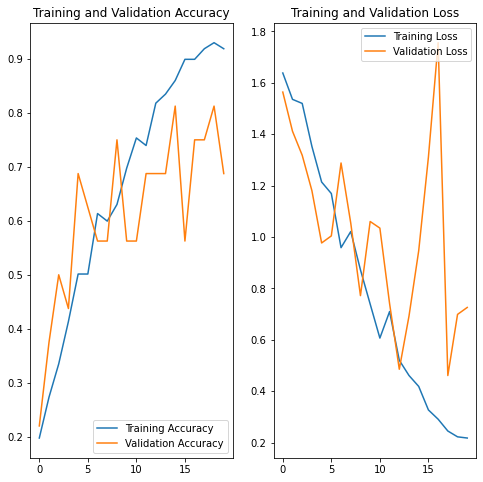

In [15]:
plot_graph(model13_history)

In [16]:
ind = model13_history.history['val_categorical_accuracy'].index(max(model13_history.history['val_categorical_accuracy']))
model13_val_acc = max(model13_history.history['val_categorical_accuracy'])
model13_trg_acc = model13_history.history['categorical_accuracy'][ind]
model13_params = model13.count_params()
print("Maximum validation accuracy:", model13_val_acc)
print("Corresponding training accuracy:", model13_trg_acc)
print("Corresponding number of parameters:", model13_params)

Maximum validation accuracy: 0.8125
Corresponding training accuracy: 0.8599439859390259
Corresponding number of parameters: 992517


It can be seen that the results are promising but the training accuracy is so low. Can't trust the model

Now trying out the same model with the full series of images but skipping alternate ones. Only even indexed images are considered, totalling to 15 numbers in total

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=10,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [18]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  15
# Image indices to be considered:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of epochs:  20


In [19]:
model14 = Sequential()
model14.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model14.add(Activation('relu'))
model14.add(MaxPooling3D(pool_size=(2, 2, 2)))

model14.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model14.add(Activation('relu'))
model14.add(MaxPooling3D(pool_size=(2, 2, 2)))

model14.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same'))
model14.add(Activation('relu'))
model14.add(MaxPooling3D(pool_size=(2, 2, 2)))

model14.add(Flatten())
model14.add(Dense(64,activation='relu'))
model14.add(Dropout(0.3))


model14.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model14.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model14.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model14.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 7, 60, 60, 32)     0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 30, 30, 32)    0         
 3D)                                                  

In [20]:
model14_history = model14.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_729/959229577.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model14_history = model14.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6254 - categorical_accuracy: 0.2006Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3014_42_33.168567/model-00001-1.62540-0.20060-1.44251-0.26000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.6254 - categorical_accuracy: 0.2006 - val_loss: 1.4425 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4632 - categorical_accuracy: 0.3354
Epoch 00002: saving model to model_init_2024-04-3014_42_33.168567/model-00002-1.46317-0.33540-1.26402-0.62500.h5
21/21 [==============================] - 48s 2s/step - loss: 1.4632 - categorical_accuracy: 0.3354 - val_loss: 1.2640 - val_categorical_accuracy: 0.6250 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

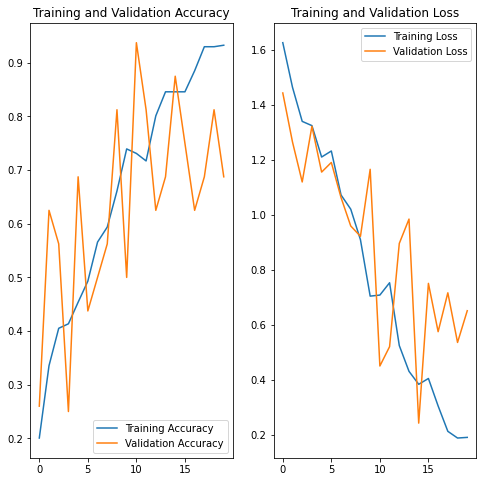

In [22]:
plot_graph(model14_history)

In [23]:
ind = model14_history.history['val_categorical_accuracy'].index(max(model14_history.history['val_categorical_accuracy']))
model14_val_acc = max(model14_history.history['val_categorical_accuracy'])
model14_trg_acc = model14_history.history['categorical_accuracy'][ind]
model14_params = model14.count_params()
print("Maximum validation accuracy:", model14_val_acc)
print("Corresponding training accuracy:", model14_trg_acc)
print("Corresponding number of parameters:", model14_params)

Maximum validation accuracy: 0.9375
Corresponding training accuracy: 0.7310924530029297
Corresponding number of parameters: 992517


The below accuracy levels are also acceptable from epoch 19. Comparatively 0.9375 seems better.

In [25]:
ind = model14_history.history['val_categorical_accuracy'].index(max(model14_history.history['val_categorical_accuracy']))
model14_val_acc_19 = model14_history.history['val_categorical_accuracy'][18]
model14_trg_acc_19 = model14_history.history['categorical_accuracy'][18]
model14_params = model14.count_params()
print("Maximum validation accuracy:", model14_val_acc_19)
print("Corresponding training accuracy:", model14_trg_acc_19)
print("Corresponding number of parameters:", model14_params)

Maximum validation accuracy: 0.8125
Corresponding training accuracy: 0.9299719929695129
Corresponding number of parameters: 992517


It can be seen that this model is also a promising one but with a bit of overfitting than the previous one

Now trying out with the same model but with L2 regularization at kernel level only for the most dense layers to check the results for overfitting

In [26]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=5, min_lr=0.0001)# write the REducelronplateau code here

earlystop = EarlyStopping(monitor="val_categorical_accuracy",patience=10,mode="auto",verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

In [27]:
image_size = 120  #Square size of the final image required
print ('# Final image size =', image_size)
batch_size = 32  #defining batch size for generator function
print ('# Batch Size =', batch_size)
img_idx = img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]#Defining image indexes for considering in training
print('# Length of image index: ', len(img_idx))
print('# Image indices to be considered: ', img_idx)
train_generator = generator(train_path, train_doc, batch_size, img_idx, image_size)
val_generator = generator(val_path, val_doc, batch_size, img_idx, image_size)
num_epochs = 20
print('# Number of epochs: ', num_epochs)

# Final image size = 120
# Batch Size = 32
# Length of image index:  15
# Image indices to be considered:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of epochs:  20


Importing regularizer library

In [28]:
from keras import regularizers

In [29]:
model15 = Sequential()
model15.add(Conv3D(filters = 16, kernel_size = (3, 3, 3), padding='same', input_shape = (len(img_idx),image_size,image_size,3)))
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Conv3D(filters = 32, kernel_size = (3, 3, 3),padding='same'))
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))#Added L2 regularizer
model15.add(Activation('relu'))
model15.add(MaxPooling3D(pool_size=(2, 2, 2)))

model15.add(Flatten())
model15.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(0.01)))#Added L2 regularizer
model15.add(Dropout(0.3))


model15.add(Dense(5))#FInal dense layer with the number of neurons equal to the numer of classes.
model15.add(Activation('softmax'))#Softmax function for the probabilities of each classes


optimizer = 'adam'#write your optimizer
model15.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model15.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 activation_9 (Activation)   (None, 7, 60, 60, 32)     0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 3, 30, 30, 32)    0         
 3D)                                                  

In [30]:
model15_history = model15.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_729/3766761971.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model15_history = model15.fit_generator(generator = train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.6580 - categorical_accuracy: 0.2081Source path =  /home/datasets/Project_data/val ; batch size = 32
Batch:  4 Index: 32 Remaining data code

Epoch 00001: saving model to model_init_2024-04-3014_42_33.168567/model-00001-2.65799-0.20814-2.12503-0.25000.h5
21/21 [==============================] - 80s 4s/step - loss: 2.6580 - categorical_accuracy: 0.2081 - val_loss: 2.1250 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.9693 - categorical_accuracy: 0.2277
Epoch 00002: saving model to model_init_2024-04-3014_42_33.168567/model-00002-1.96932-0.22774-1.74943-0.25000.h5
21/21 [==============================] - 50s 3s/step - loss: 1.9693 - categorical_accuracy: 0.2277 - val_loss: 1.7494 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0

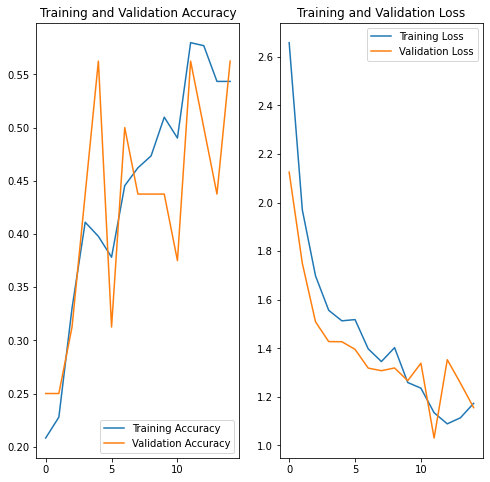

In [32]:
plot_graph(model15_history)

In [33]:
ind = model15_history.history['val_categorical_accuracy'].index(max(model15_history.history['val_categorical_accuracy']))
model15_val_acc = max(model15_history.history['val_categorical_accuracy'])
model15_trg_acc = model15_history.history['categorical_accuracy'][ind]
model15_params = model15.count_params()
print("Maximum validation accuracy:", model15_val_acc)
print("Corresponding training accuracy:", model15_trg_acc)
print("Corresponding number of parameters:", model15_params)

Maximum validation accuracy: 0.5625
Corresponding training accuracy: 0.3977591097354889
Corresponding number of parameters: 992517


It can be observed that the maximum validation accuracy reduced drastically after adding an L2 regularization layer. Meaning it was not required and did more harm than good.

### To sumarize

#### Summary of the accuracies and parameters

In [36]:
import pandas as pd
summary_dict = {
    'Model Name': ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7', 'model8', 'model9', 'model10', 'model11', 'model12', 'model13', 'model14', 'model15'],
    'Validation Accuracy': [model1_val_acc, model2_val_acc,model3_val_acc,'GPU OOM',model5_val_acc,model6_val_acc,model7_val_acc,model8_val_acc,model9_val_acc,model10_val_acc,model11_val_acc,model12_val_acc,model13_val_acc,model14_val_acc,model15_val_acc],
    'Training Accuracy': [model1_trg_acc, model2_trg_acc, model3_trg_acc, 'GPU OOM', model5_trg_acc, model6_trg_acc, model7_trg_acc, model8_trg_acc, model9_trg_acc, model10_trg_acc, model11_trg_acc, model12_trg_acc, model13_trg_acc, model14_trg_acc, model15_trg_acc ],
    'No. of Parameters': [model1_params, model2_params,model3_params,model4_params,model5_params,model6_params,model7_params,model8_params,model9_params,model10_params,model11_params,model12_params,model13_params,model14_params,model15_params]
}

summary_df = pd.DataFrame(summary_dict)
summary_df

,Model Name,Validation Accuracy,Training Accuracy,No. of Parameters
0,model1,0.3055,0.1845,698565
1,model2,0.3333,0.2559,15875461
2,model3,0.4444,0.375,501957
3,model4,GPU OOM,GPU OOM,151046405
4,model5,0.28,0.2008,69126917
5,model6,0.5278,0.3155,502661
6,model7,0.4167,0.2321,697797
7,model8,0.5,0.3155,1111941
8,model9,0.8125,0.8655,2835717
9,model10,0.8125,0.591,2835973


#### Summary

(1) 15 different models were tried out with varying configurations as mentioned below<br><br>
                - Varied architecture<br>
                - Varied number of images in the input stream of images<br>
                - Batch size<br>
                - image size<br>
                - Different regularization methods as L2, BatchNormalization, Dropouts<br><br>
(2) Reasonable accuracies were found for some of the later models.<br><br>
(3) The best recommended accuracy was found to be for  model13 with the following results. The accuracy is reasonable and the considering that this isthe least overfitting model among the multiple models experimented with. Moreover the number of parameters is also not high, but reasonable for a good model.<br><br>
                - Maximum validation accuracy: 0.8125<br>
                - Corresponding training accuracy: 0.8599<br>
                - Corresponding number of parameters: 992517<br><br>
(4) There are other models with high validataion accuracies. For instance: model14.<br><br>
                - Maximum validation accuracy: 0.9375<br>
                - Corresponding training accuracy: 0.7311<br>
                - Corresponding number of parameters: 992517<br><br>
    This model, though having a very good validation accuracy seems not reliable because the delta between the training accuracy and the validation accuracy is very high towards the side of UNDER fitting. Reason is to be investigated. <br>Similarly model 12 with 0.875 as the validation accuracy and 0.795 as the training accuracy..here too training accuracy is much lesser than validation accuracy which happens but not usual. <br><br>
(5) It may be noted that model4 was not run since the GPU capacity was not enough to run the dense first layer with 512 neurons. This was an experiment to prove that the number of neurons cannot be increased as you wish, rather is limited by the GPU capacity. In model5, the same architecture was used, but with reduced batch size and it was found to be running in the same GPU.<br><br>

### To conclude
#### considering various aspects like explainability, least overfitting, reasonable accuracy values, a conservative decision os taken to go for model13, accuracy and parameter details are mentioned below. The number of parameters are also reasonably low. As mentioned towards the beginning after having an exploratory data analysis, the last few images in the stream are not contributing much. The model no 13 is considering only the first 15 images in the video stream. More details are mentioned in the detailed report as part of this project.
                - Maximum validation accuracy: 0.8125
                - Corresponding training accuracy: 0.8599
                - Corresponding number of parameters: 992517
                - Corresponding input image size: 120x120
                - Corresponding batch size: 32




#### Architecture of recommended model : model13

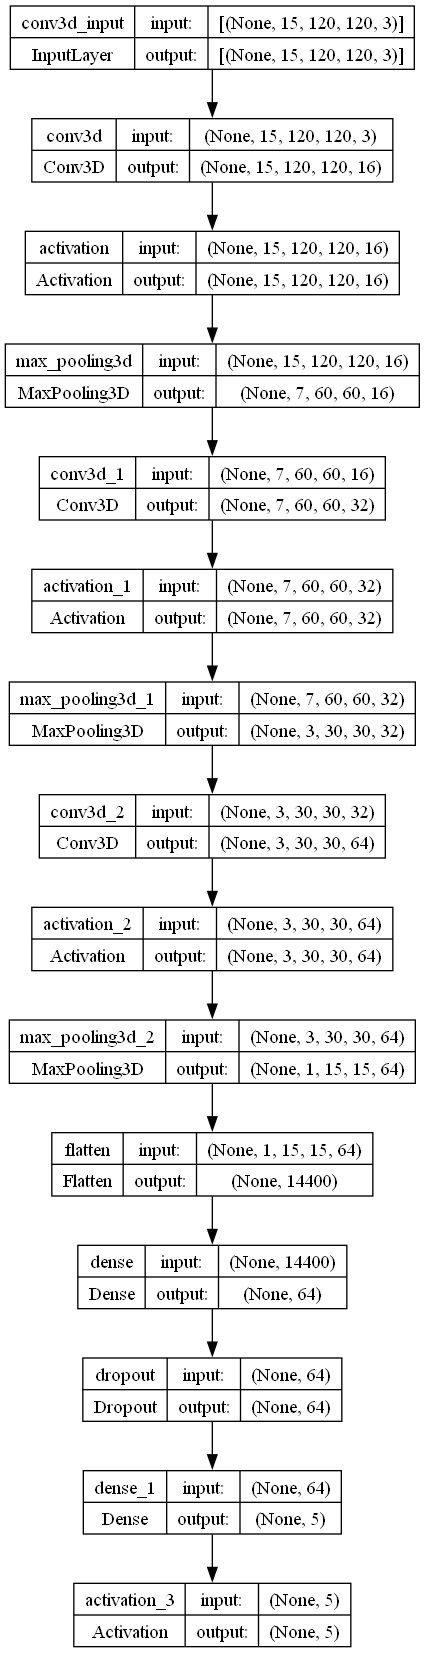

In [12]:
plot_model(model13, to_file='model_plot.png', show_shapes=True, show_layer_names=True)